In [1]:
import numpy as np
import pandas as pd

In [2]:
hist_data = pd.read_csv('historical_data.csv')

# Exploratory Data Analysis

In [3]:
hist_data.head()

,market_id,created_at,actual_delivery_time,store_id,subtotal,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,3441,33.0,14.0,21.0,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,1900,1.0,2.0,2.0,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,1900,1.0,0.0,0.0,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,6900,1.0,1.0,2.0,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,3900,6.0,6.0,9.0,650.0


In [4]:
hist_data.shape

(197428, 9)

In [5]:
hist_data.describe()

,market_id,store_id,subtotal,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration
count,196441.000000,197428.000000,197428.000000,181166.000000,181166.000000,181166.000000,196902.000000
mean,2.978706,3530.510272,2682.331402,44.808093,41.739747,58.050065,545.358935
std,1.524867,2053.496711,1823.093688,34.526783,32.145733,52.661830,219.352902
min,1.000000,1.000000,0.000000,-4.000000,-5.000000,-6.000000,0.000000
25%,2.000000,1686.000000,1400.000000,17.000000,15.000000,17.000000,382.000000
50%,3.000000,3592.000000,2200.000000,37.000000,34.000000,41.000000,544.000000
75%,4.000000,5299.000000,3395.000000,65.000000,62.000000,85.000000,702.000000
max,6.000000,6987.000000,27100.000000,171.000000,154.000000,285.000000,2088.000000


In [6]:
print(hist_data.isna().sum()/len(hist_data))

market_id                                       0.004999
created_at                                      0.000000
actual_delivery_time                            0.000035
store_id                                        0.000000
subtotal                                        0.000000
total_onshift_dashers                           0.082369
total_busy_dashers                              0.082369
total_outstanding_orders                        0.082369
estimated_store_to_consumer_driving_duration    0.002664
dtype: float64


In [7]:
hist_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 9 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   subtotal                                      197428 non-null  int64  
 5   total_onshift_dashers                         181166 non-null  float64
 6   total_busy_dashers                            181166 non-null  float64
 7   total_outstanding_orders                      181166 non-null  float64
 8   estimated_store_to_consumer_driving_duration  196902 non-null  float64
dtypes: float64(5), int64(2), object(2)
memory usage: 

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

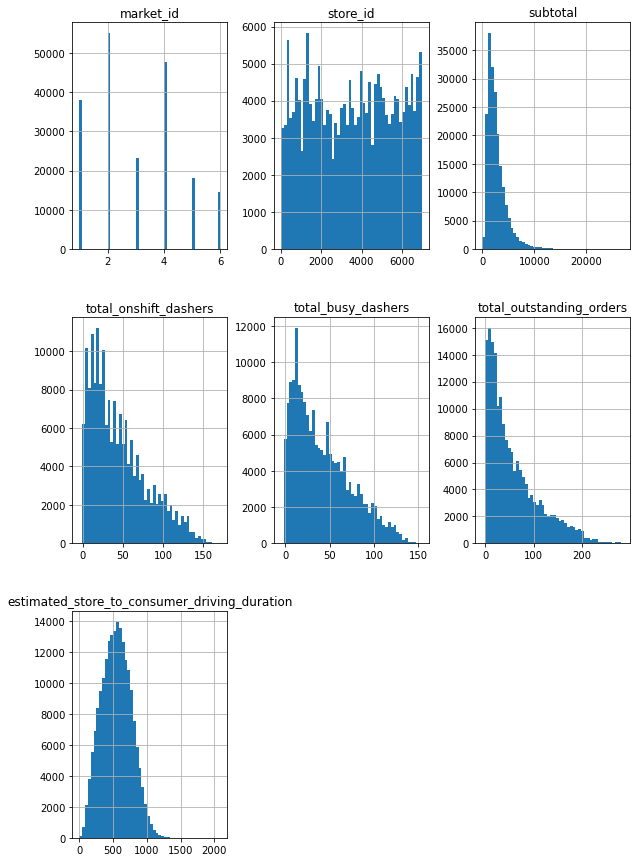

In [10]:
_ = hist_data.hist(bins=50, figsize=(10,15))

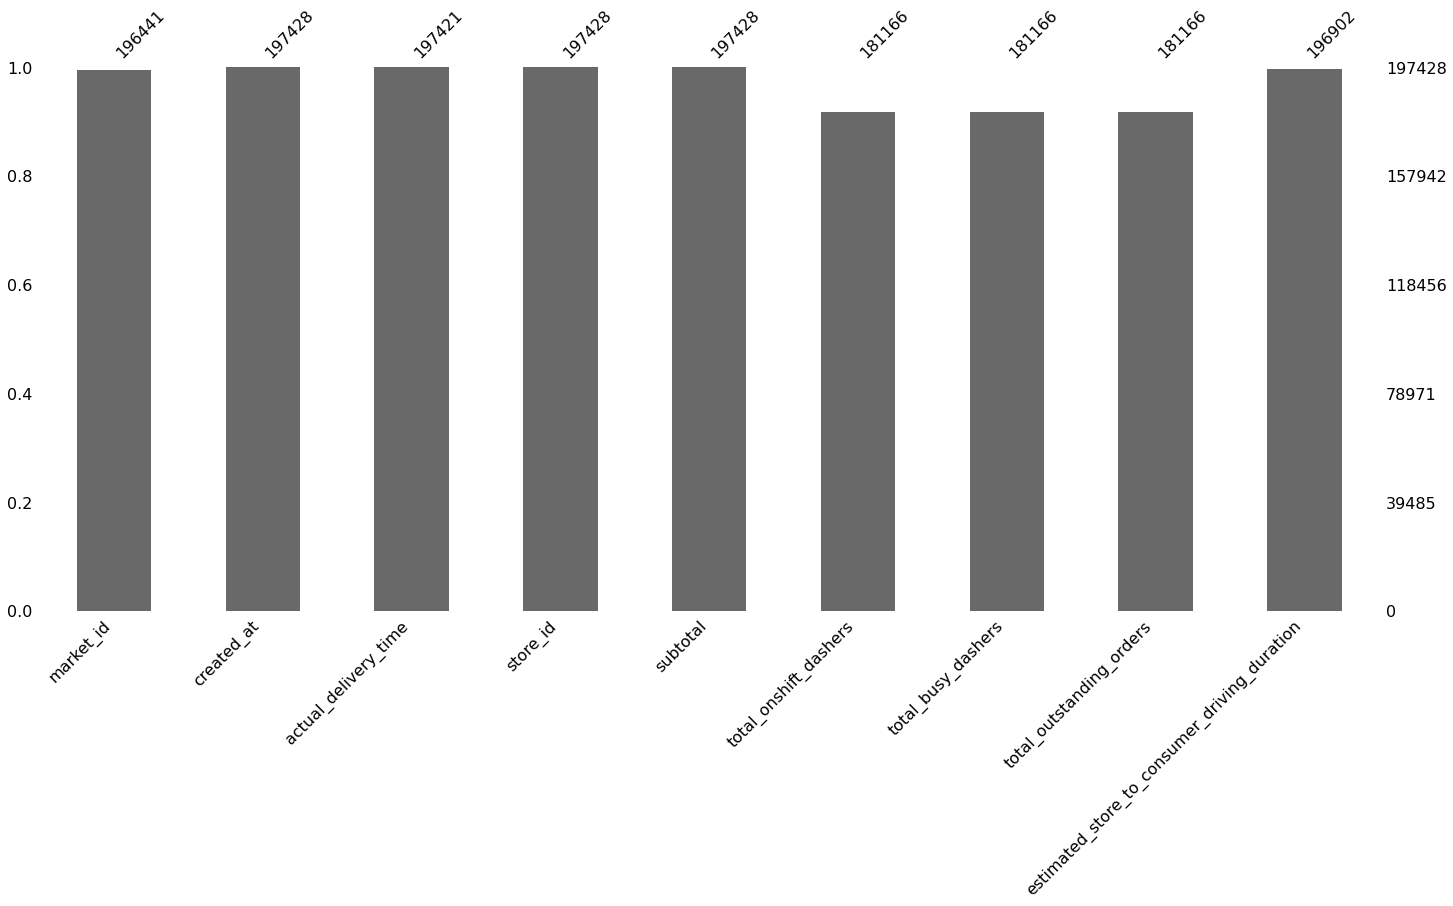

In [11]:
import missingno as msno
_ = msno.bar(hist_data)

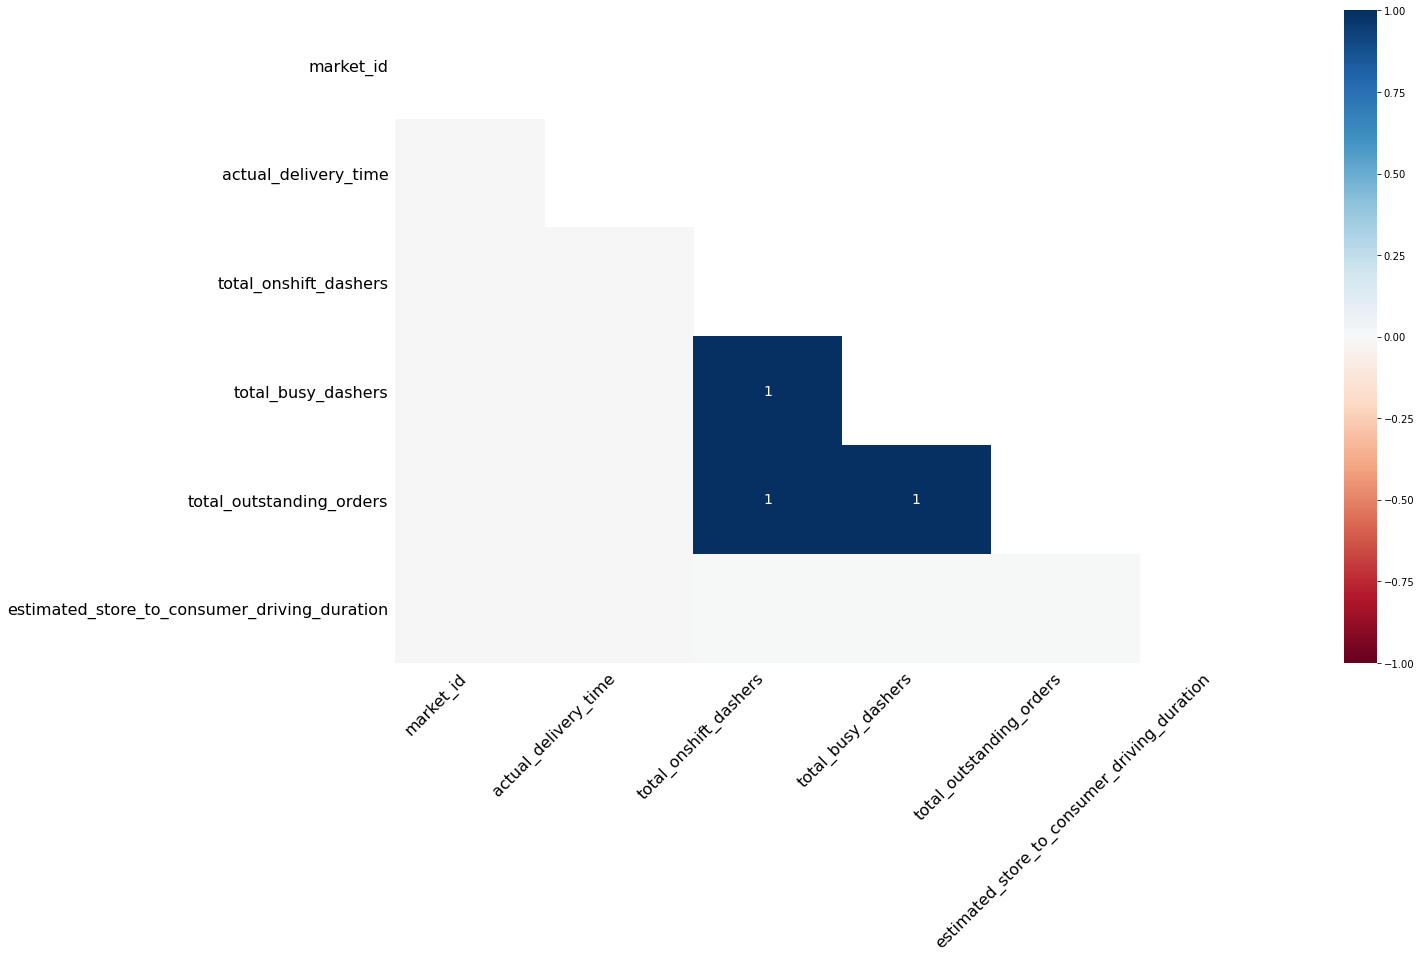

In [12]:
_ = msno.heatmap(hist_data)

#### So far, I've been identified the following data preprocessing steps:  
#### 1. Fill in missing market_id with store id whenever possible  
#### 2. Deal with missing and negative values for total_busy_dashers, total_outstanding_orders, total_onshift_dashers  
#### 3. Estimate values for features above using median value (a more advanced version of the model would estimate values based on median/mean for specific market at given time of day)
#### 4. Create features: total_delivery_duration_seconds and outstanding_orders_per_available_dasher

In [13]:
hist_data.dtypes

market_id                                       float64
created_at                                       object
actual_delivery_time                             object
store_id                                          int64
subtotal                                          int64
total_onshift_dashers                           float64
total_busy_dashers                              float64
total_outstanding_orders                        float64
estimated_store_to_consumer_driving_duration    float64
dtype: object

In [14]:
hist_data['created_at'] = pd.to_datetime(hist_data['created_at'], infer_datetime_format=True)

In [15]:
hist_data['actual_delivery_time'] = pd.to_datetime(hist_data['actual_delivery_time'], infer_datetime_format=True)

In [16]:
hist_data.dtypes

market_id                                              float64
created_at                                      datetime64[ns]
actual_delivery_time                            datetime64[ns]
store_id                                                 int64
subtotal                                                 int64
total_onshift_dashers                                  float64
total_busy_dashers                                     float64
total_outstanding_orders                               float64
estimated_store_to_consumer_driving_duration           float64
dtype: object

In [17]:
hist_data['total_delivery_duration_seconds'] = (hist_data['actual_delivery_time'] - \
                                                    hist_data['created_at']).dt.total_seconds()

In [18]:
hist_data.head()

,market_id,created_at,actual_delivery_time,store_id,subtotal,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,total_delivery_duration_seconds
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,3441,33.0,14.0,21.0,861.0,3779.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,1900,1.0,2.0,2.0,690.0,4024.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,1900,1.0,0.0,0.0,690.0,1781.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,6900,1.0,1.0,2.0,289.0,3075.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,3900,6.0,6.0,9.0,650.0,2390.0


In [19]:
hist_data.dtypes

market_id                                              float64
created_at                                      datetime64[ns]
actual_delivery_time                            datetime64[ns]
store_id                                                 int64
subtotal                                                 int64
total_onshift_dashers                                  float64
total_busy_dashers                                     float64
total_outstanding_orders                               float64
estimated_store_to_consumer_driving_duration           float64
total_delivery_duration_seconds                        float64
dtype: object

#### Let's now check if the distribution of seconds makes sense - i.e. if there are any negative values or outliers we'd need to deal with. First, let's create a numpy array of total delivery minutes since it's easier to interpret compared to seconds.

In [20]:
delivery_minutes = np.array(hist_data['total_delivery_duration_seconds'].values.tolist())/60

In [21]:
np.percentile(delivery_minutes, [25,50,75,100])

array([nan, nan, nan, nan])

In [22]:
delivery_minutes = delivery_minutes[~np.isnan(delivery_minutes)]

In [23]:
np.percentile(delivery_minutes, [25,50,75,100])

array([3.50666667e+01, 4.43333333e+01, 5.63500000e+01, 1.41947650e+05])

In [24]:
outliers = delivery_minutes[delivery_minutes >= 180]

In [25]:
outliers.shape

(138,)

In [26]:
outliers = delivery_minutes[delivery_minutes >= 300]

In [27]:
outliers.shape

(35,)

So we have 35 instances of deliveries taking longer than 5 hours and 138 instances of them taking longer than 3 hours.

In [28]:
q25 = np.percentile(delivery_minutes, 25)
q75 = np.percentile(delivery_minutes, 75)
iqr = q75 - q25

In [35]:
print(iqr)

21.28333333333333


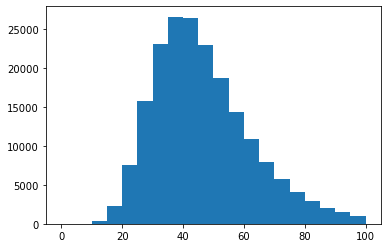

In [43]:
_ = plt.hist(delivery_minutes, bins=[x * 5 for x in range(0,21)])

In [44]:
print(delivery_minutes[delivery_minutes < (q25 - 1.5 * iqr)].shape)

(1,)


In [47]:
print(delivery_minutes[delivery_minutes > (q75 + 1.5 * iqr)].shape)

(6277,)


So the classic IQR method yields 1 low outlier and 6277 'high' outliers.

Let's investigate this in the dataframe itself.

In [49]:
q25 = q25*60
q75 = q75*60

In [59]:
print(q25, q75)

2104.0 3381.0


In [61]:
iqr = q75-q25

In [62]:
hist_data['is_outlier'] = False
hist_data.loc[hist_data['total_delivery_duration_seconds'] > (q75+1.5*iqr), 'is_outlier'] = True
hist_data.loc[hist_data['total_delivery_duration_seconds'] < (q25-1.5*iqr), 'is_outlier'] = True
outlier_df = hist_data[hist_data['is_outlier'] == True]

In [63]:
print(outlier_df.shape)

(6278, 11)


In [65]:
outlier_df['subtotal'].describe()

count     6278.000000
mean      3345.850749
std       2417.580929
min          0.000000
25%       1670.000000
50%       2695.000000
75%       4250.000000
max      27100.000000
Name: subtotal, dtype: float64

In [66]:
print(outlier_df.describe())

         market_id     store_id      subtotal  total_onshift_dashers  \
count  6246.000000  6278.000000   6278.000000            5729.000000   
mean      2.652418  3461.202134   3345.850749              38.962297   
std       1.626069  2037.089220   2417.580929              34.943485   
min       1.000000     4.000000      0.000000              -1.000000   
25%       1.000000  1661.000000   1670.000000              11.000000   
50%       2.000000  3471.000000   2695.000000              27.000000   
75%       4.000000  5173.000000   4250.000000              59.000000   
max       6.000000  6983.000000  27100.000000             157.000000   

       total_busy_dashers  total_outstanding_orders  \
count         5729.000000               5729.000000   
mean            37.760342                 63.648281   
std             32.992434                 60.525781   
min              0.000000                 -5.000000   
25%             11.000000                 16.000000   
50%             26.00

These outliers appear random, as in the other features' values do not indicate there is any sort of sampling bias at play. In other words, they are likely to be random data entry errors. With that in mind, and considering that they only consist of around 3% of rows, I believe it is safe to delete them. The only caveat I would point out here is that we should combine the IQR method with a bit of business sense and not remove orders below 2 hours, as it is not unthinkable that this might occur.

In [69]:
outlier_df2 = outlier_df[outlier_df['total_delivery_duration_seconds'] <= 7200]

In [70]:
outlier_df2.describe()

,market_id,store_id,subtotal,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,total_delivery_duration_seconds
count,5165.000000,5188.000000,5188.000000,4722.000000,4722.000000,4722.000000,5183.000000,5188.000000
mean,2.659439,3475.075559,3381.217232,39.602922,38.445362,64.752647,619.224580,5931.861218
std,1.627844,2036.048467,2444.056885,35.271226,33.362999,61.122749,222.835044,501.145693
min,1.000000,4.000000,0.000000,-1.000000,0.000000,-5.000000,1.000000,101.000000
25%,1.000000,1661.000000,1691.500000,11.000000,11.000000,16.000000,465.000000,5516.750000
50%,2.000000,3491.000000,2699.000000,27.000000,26.000000,41.000000,624.000000,5807.000000
75%,4.000000,5183.250000,4274.250000,60.000000,59.000000,99.000000,774.000000,6280.250000
max,6.000000,6983.000000,19650.000000,157.000000,148.000000,278.000000,1739.000000,7196.000000


The quick check above reveals no bias here either.

The last steps before splitting training and test sets and creating preprocessing pipelines will be:  create the other variable we needed, total outstanding orders per available dasher, examine feature correlations, and examining the number of negative values for features where that does not make sense.

In [143]:
hist_data = pd.read_csv('historical_data.csv')
hist_data['avail_dasher'] = hist_data['total_onshift_dashers'] - hist_data['total_busy_dashers']
hist_data['out_orders_per_avail_dasher'] = hist_data['total_outstanding_orders']/hist_data['avail_dasher']
hist_data['created_at'] = pd.to_datetime(hist_data['created_at'], infer_datetime_format=True)
hist_data['actual_delivery_time'] = pd.to_datetime(hist_data['actual_delivery_time'], infer_datetime_format=True)
hist_data['total_delivery_duration_seconds'] = (hist_data['actual_delivery_time'] - \
                                                    hist_data['created_at']).dt.total_seconds()
corr_matrix = hist_data.corr()
corr_matrix['total_delivery_duration_seconds'].sort_values(ascending=False)

total_delivery_duration_seconds                 1.000000
total_outstanding_orders                        0.122294
total_busy_dashers                              0.060641
total_onshift_dashers                           0.046972
out_orders_per_avail_dasher                     0.031700
estimated_store_to_consumer_driving_duration    0.012198
subtotal                                        0.011200
store_id                                       -0.000414
market_id                                      -0.005784
avail_dasher                                   -0.028682
Name: total_delivery_duration_seconds, dtype: float64

In [77]:
test = hist_data[hist_data['total_onshift_dashers'] < 0]

In [78]:
print(test.shape)

(21, 11)


In [80]:
test = hist_data[hist_data['total_outstanding_orders'] < 0]

In [81]:
print(test.shape)

(44, 11)


## Now, let's split the data and create the pipelines.

In [85]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [83]:
hist_data = pd.read_csv('historical_data.csv')

In [114]:
train_set, test_set = train_test_split(hist_data, test_size=0.2, random_state=42)

In [117]:
# Custom transformer to extract labels (delivery time) from new data
class DeliveryTimeCalculator(BaseEstimator, TransformerMixin):

	def __init__(self, upper_outlier_seconds = None):
		self.fixed_threshold = upper_outlier_seconds

	def fit(self, X, y=None):
		return self

	def transform(self, X):
		assert isinstance(X, (pd.Series, pd.DataFrame))
		X = X.copy()
		X['created_at'] = pd.to_datetime(X['created_at'], infer_datetime_format=True)
		X['actual_delivery_time'] = pd.to_datetime(X['actual_delivery_time'], infer_datetime_format=True)
		X['total_delivery_duration_seconds'] = (X['actual_delivery_time'] - \
                                                    X['created_at']).dt.total_seconds()

		
		seconds_array = X['total_delivery_duration_seconds'].to_numpy()
		seconds_array = seconds_array[~np.isnan(seconds_array)]
		q25 = np.percentile(seconds_array, 25)
		q75 = np.percentile(seconds_array, 75)
		iqr = q75 - q25

		lo_threshold = q25 - 1.5 * iqr

		if self.fixed_threshold is None:
			hi_threshold = q75 + 1.5 * iqr
		else:
			hi_threshold = self.fixed_threshold


		X['is_outlier'] = False
		X.loc[X['total_delivery_duration_seconds'] > hi_threshold, 'is_outlier'] = True
		X.loc[X['total_delivery_duration_seconds'] < lo_threshold, 'is_outlier'] = True
		X = X[X['is_outlier'] == False]
		X = X.drop('is_outlier', axis=1)

		return X

In [118]:
train_set = DeliveryTimeCalculator(upper_outlier_seconds=7200).fit_transform(train_set)

In [120]:
print(train_set.head())

        market_id          created_at actual_delivery_time  store_id  \
178523        3.0 2015-02-10 02:25:28  2015-02-10 03:09:01      1659   
89414         4.0 2015-01-23 04:23:13  2015-01-23 05:01:12      3748   
94190         1.0 2015-01-24 03:33:32  2015-01-24 04:03:35      6750   
136117        5.0 2015-02-17 00:25:38  2015-02-17 01:14:22      6456   
53337         4.0 2015-01-26 01:19:16  2015-01-26 02:24:02      6889   

        subtotal  total_onshift_dashers  total_busy_dashers  \
178523      1298                    0.0                 0.0   
89414       1690                   78.0                64.0   
94190       3300                   63.0                66.0   
136117      3029                   23.0                15.0   
53337       3390                   71.0                98.0   

        total_outstanding_orders  \
178523                       0.0   
89414                       75.0   
94190                       90.0   
136117                      15.0   
53337   

In [122]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

In [123]:
MARKET_FEATURES = ['total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders']
NUM_FEATURES = ['store_id', 'subtotal', 'estimated_store_to_consumer_driving_duration']
train_labels = train_set['total_delivery_duration_seconds'].to_numpy()

In [124]:
market_pipeline = Pipeline([('mkt_feat_processer', MarketFeatureProcesser()), ('imputer', SimpleImputer(strategy='median')), \
										('scaler', StandardScaler())])
num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
full_pipeline = ColumnTransformer([('market', market_pipeline,MARKET_FEATURES), ('num', num_pipeline, NUM_FEATURES)])

In [126]:
debug_set = train_set[MARKET_FEATURES]

In [129]:
debug_set = train_set[MARKET_FEATURES].copy()

In [130]:
debug_set[debug_set < 0] = np.nan

In [131]:
print(debug_set)

        total_onshift_dashers  total_busy_dashers  total_outstanding_orders
178523                    0.0                 0.0                       0.0
89414                    78.0                64.0                      75.0
94190                    63.0                66.0                      90.0
136117                   23.0                15.0                      15.0
53337                    71.0                98.0                      91.0
...                       ...                 ...                       ...
119879                   56.0                69.0                      66.0
103694                   50.0                51.0                      62.0
131932                   51.0                49.0                      78.0
146867                   38.0                64.0                      81.0
121958                    NaN                 NaN                       NaN

[157059 rows x 3 columns]


In [132]:
debug_set.isna()

,total_onshift_dashers,total_busy_dashers,total_outstanding_orders
178523,False,False,False
89414,False,False,False
94190,False,False,False
136117,False,False,False
53337,False,False,False
...,...,...,...
119879,False,False,False
103694,False,False,False
131932,False,False,False
146867,False,False,False


In [133]:
debug_set.isna().sum()

total_onshift_dashers       12976
total_busy_dashers          12976
total_outstanding_orders    12992
dtype: int64

In [134]:
debug_set = train_set[MARKET_FEATURES].copy()

In [139]:
debug_set = MarketFeatureProcesser().fit_transform(debug_set)

In [140]:
debug_set.describe()

,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,avail_dasher,out_orders_per_avail_dasher
count,144083.000000,144083.000000,144067.000000,111998.000000,1.092160e+05
mean,44.772714,41.700090,57.927291,6.243978,inf
std,34.474992,32.093658,52.556587,9.417286,NaN
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,17.000000,15.000000,17.000000,0.000000,8.849558e-03
50%,37.000000,34.000000,41.000000,3.000000,6.896552e-02
75%,65.000000,62.000000,84.000000,8.000000,2.307692e-01
max,171.000000,154.000000,285.000000,86.000000,inf


In [145]:
# Custom transformer to handle market features and create new ones
class MarketFeatureProcesser(BaseEstimator, TransformerMixin):

	def __init__(self, add_out_order_per_avail_dasher = True):
		self.add_out_order_per_avail_dasher = add_out_order_per_avail_dasher

	def fit(self, X, y=None):
		return self

	def transform(self, X):
		assert isinstance(X, (pd.Series, pd.DataFrame))
		X = X.copy()
		# Replacing all negative values of these features with np.nan, to be 
		# processed with a built-in imputer later on in the pipeline

		if self.add_out_order_per_avail_dasher:
			X['avail_dasher'] = X['total_onshift_dashers'] - X['total_busy_dashers']
			X['out_orders_per_avail_dasher'] = X['total_outstanding_orders']
			X.loc[~(X['avail_dasher'] == 0), 'out_orders_per_avail_dasher'] = X['total_outstanding_orders']/X['avail_dasher']

		X[X < 0] = np.nan 

		return X

In [146]:
debug_set = train_set[MARKET_FEATURES].copy()

In [147]:
market_pipeline = Pipeline([('mkt_feat_processer', MarketFeatureProcesser()), ('imputer', SimpleImputer(strategy='median')), \
										('scaler', StandardScaler())])

In [148]:
debug_set = market_pipeline.fit_transform(debug_set)

In [149]:
print(debug_set)

[[-1.33367991 -1.33271544 -1.11821289 -0.65709287 -0.69646172]
 [ 1.02357711  0.74438268  0.36543002  1.07412914 -0.50257517]
 [ 0.57025845  0.809292    0.6621586  -0.28611672 -0.33454016]
 ...
 [ 0.20760353  0.25756281  0.42477573 -0.40977544  0.71503236]
 [-0.18527264  0.74438268  0.48412145 -0.28611672 -0.33454016]
 [-0.21549389 -0.22925707 -0.30715477 -0.28611672 -0.33454016]]


In [155]:
train_set_transformed = full_pipeline.fit_transform(train_set)

# Model training and evaluation

In [156]:
from sklearn.linear_model import LinearRegression

In [157]:
lin_reg = LinearRegression()

In [162]:
train_set_transformed = full_pipeline.fit_transform(train_set)

In [163]:
hist_data = pd.read_csv('historical_data.csv')
train_set, test_set = train_test_split(hist_data, test_size=0.2, random_state=42)
train_set = DeliveryTimeCalculator(upper_outlier_seconds=7200).fit_transform(train_set)
train_labels = train_set['total_delivery_duration_seconds'].to_numpy()

In [164]:
train_set_transformed = full_pipeline.fit_transform(train_set)

In [165]:
print(train_set_transformed)

[[-1.33367991 -1.33271544 -1.11821289 ... -0.91085201 -0.75992601
   1.26480515]
 [ 1.02357711  0.74438268  0.36543002 ...  0.1057256  -0.54413457
  -0.63233486]
 [ 0.57025845  0.809292    0.6621586  ...  1.56659969  0.3421517
  -1.13519124]
 ...
 [ 0.20760353  0.25756281  0.42477573 ... -0.41059266 -0.48908573
   0.51052057]
 [-0.18527264  0.74438268  0.48412145 ...  0.05608897 -0.7037762
  -0.99804859]
 [-0.21549389 -0.22925707 -0.30715477 ... -0.10644666 -0.15328783
  -0.98433433]]


In [184]:
class DeliveryTimeCalculator(BaseEstimator, TransformerMixin):

	def __init__(self, upper_outlier_seconds = None):
		self.fixed_threshold = upper_outlier_seconds

	def fit(self, X, y=None):
		return self

	def transform(self, X):
		assert isinstance(X, (pd.Series, pd.DataFrame))
		X = X.copy()
		X['created_at'] = pd.to_datetime(X['created_at'], infer_datetime_format=True)
		X['actual_delivery_time'] = pd.to_datetime(X['actual_delivery_time'], infer_datetime_format=True)
		X['total_delivery_duration_seconds'] = (X['actual_delivery_time'] - \
                                                    X['created_at']).dt.total_seconds()

		
		seconds_array = X['total_delivery_duration_seconds'].to_numpy()
		seconds_array = seconds_array[~np.isnan(seconds_array)]
		q25 = np.percentile(seconds_array, 25)
		q75 = np.percentile(seconds_array, 75)
		iqr = q75 - q25

		lo_threshold = q25 - 1.5 * iqr

		if self.fixed_threshold is None:
			hi_threshold = q75 + 1.5 * iqr
		else:
			hi_threshold = self.fixed_threshold


		X['is_outlier'] = False
		X.loc[X['total_delivery_duration_seconds'] > hi_threshold, 'is_outlier'] = True
		X.loc[X['total_delivery_duration_seconds'] < lo_threshold, 'is_outlier'] = True
		X = X[X['is_outlier'] == False]
		X = X.drop('is_outlier', axis=1)
		X = X.dropna(subset=['total_delivery_duration_seconds'])

		return X

In [185]:
hist_data = pd.read_csv('historical_data.csv')
train_set, test_set = train_test_split(hist_data, test_size=0.2, random_state=42)
train_set = DeliveryTimeCalculator(upper_outlier_seconds=7200).fit_transform(train_set)
train_labels = train_set['total_delivery_duration_seconds'].to_numpy()

In [186]:
train_set_transformed = full_pipeline.fit_transform(train_set)

In [187]:
lin_reg.fit(train_set_transformed, train_labels)

LinearRegression()

In [189]:
from sklearn.metrics import mean_squared_error as MSE
lin_reg_predictions = lin_reg.predict(train_set_transformed)
lin_rmse = np.sqrt(MSE(train_labels, lin_reg_predictions))

In [190]:
print(lin_rmse)

898.686278495809


In [191]:
from sklearn.ensemble import RandomForestRegressor

In [192]:
forest_reg = RandomForestRegressor()

In [193]:
forest_reg.fit(train_set_transformed, train_labels)


RandomForestRegressor()

In [194]:
forest_reg_predictions = forest_reg.predict(train_set_transformed)
forest_rmse = np.sqrt(MSE(train_labels, forest_reg_predictions))

In [195]:
print(forest_rmse)

333.66366816751815


## Right off the bat, we see that the Random Forest model reduced our RMSE from around 15 minutes (w/ the Linear Regression model) to only 5 minutes, an approximate 2/3 reduction. Let's perform a more robust evaluation using cross-validation before deciding to stick with the Random Forest over Linear Regression.

In [196]:
from sklearn.model_selection import cross_val_score

In [199]:
def score_regressor(model, X, y):
	"""Calculates Root Mean Squared Error scores, along with their mean and std. dev, for a given regressor
		utilizing 5-fold cross-validation."""

	# Compute cross-validated Acc. scores: cv_rmse
	cv_neg_mse = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')

	cv_rmse = np.sqrt(-cv_neg_mse)

	# Print list of RMSE scores
	print(f"RMSE scores computed using 5-fold cross-validation: {cv_rmse}")
	print(f"Mean RMSE computed using 5-fold cross-validation: {cv_rmse.mean()}")
	print(f"RMSE std. deviation computed using 5-fold cross-validation: {cv_rmse.std()}")

In [200]:
score_regressor(lin_reg, train_set_transformed, train_labels)

RMSE scores computed using 5-fold cross-validation: [900.27476218 900.13621552 900.41763176 894.81853303 898.05901578]
Mean RMSE computed using 5-fold cross-validation: 898.7412316534637
RMSE std. deviation computed using 5-fold cross-validation: 2.1429417234379713


In [201]:
score_regressor(forest_reg, train_set_transformed, train_labels)

RMSE scores computed using 5-fold cross-validation: [892.0879444  888.73088272 893.91966058 889.17441039 888.92954754]
Mean RMSE computed using 5-fold cross-validation: 890.5684891254641
RMSE std. deviation computed using 5-fold cross-validation: 2.0758360624301293


## So it appears the work isn't done yet, the Random Forest was merely overfitting the training set as evidenced by the fact that its 5-fold cross-validation scores was very similar to that of the linear regression model.

## The next few dozens cells in this notebook contain my search for the best-performing model and its hyperparameters, feel free to skip down to when I land on a GradientBoostingRegressor, which will be the final model.

In [206]:
from sklearn.model_selection import RandomizedSearchCV
param_grid = [{'n_estimators': [5, 15, 25], 'max_features': [2, 4, 6, 8], \
					'max_depth':[2,4,6,8],'min_samples_leaf': [0.1, 0.2, 0.3]}]
forest_rand = RandomForestRegressor()
rand_search = RandomizedSearchCV(forest_rand, param_grid, cv=10, scoring='neg_mean_squared_error')

In [207]:
rand_search.fit(train_set_transformed, train_labels)

RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(),
                   param_distributions=[{'max_depth': [2, 4, 6, 8],
                                         'max_features': [2, 4, 6, 8],
                                         'min_samples_leaf': [0.1, 0.2, 0.3],
                                         'n_estimators': [5, 15, 25]}],
                   scoring='neg_mean_squared_error')

In [208]:
final_model = rand_search.best_estimator_

In [209]:
score_regressor(final_model, train_set_transformed, train_labels)

RMSE scores computed using 5-fold cross-validation: [974.12102758 978.16016715 979.20944789 976.54795352 975.25886527]
Mean RMSE computed using 5-fold cross-validation: 976.6594922819324
RMSE std. deviation computed using 5-fold cross-validation: 1.8532295385832003


In [210]:
rand_search.best_params_


{'n_estimators': 15,
 'min_samples_leaf': 0.1,
 'max_features': 8,
 'max_depth': 2}

In [211]:
from sklearn.model_selection import RandomizedSearchCV
param_grid = [{'n_estimators': [5, 15, 25, 30], 'max_features': [2, 4, 6, 8, 10], \
					'max_depth':[2,4,6,8],'min_samples_leaf': [0.01, 0.05, 0.1]}]
forest_rand = RandomForestRegressor()
rand_search = RandomizedSearchCV(forest_rand, param_grid, cv=10, scoring='neg_mean_squared_error')

In [213]:
from sklearn.preprocessing import PolynomialFeatures

In [215]:
poly = PolynomialFeatures(2)

In [216]:
test = poly.fit(train_set_transformed)

In [218]:
print(test)

PolynomialFeatures()


In [219]:
print(train_set_transformed)

[[-1.33368586 -1.3327136  -1.11821409 ... -0.91089697 -0.7599103
   1.26481477]
 [ 1.02365998  0.7444424   0.36549991 ...  0.1056853  -0.54412062
  -0.63231426]
 [ 0.57032424  0.80935352  0.66224271 ...  1.56656608  0.34215843
  -1.13516773]
 ...
 [ 0.20765565  0.25760896  0.42484847 ... -0.41063533 -0.48907223
   0.51053455]
 [-0.18523532  0.7444424   0.48419703 ...  0.05604844 -0.70376094
  -0.99802587]
 [-0.21545771 -0.22922448 -0.3071171  ... -0.10648793 -0.15327706
  -0.98431169]]


In [220]:
print(train_set_transformed.shape)

(157053, 8)


In [221]:
poly.fit(train_set_transformed)

PolynomialFeatures()

In [222]:
test = poly.fit_transform(train_set_transformed)

In [223]:
print(test)

[[ 1.         -1.33368586 -1.3327136  ...  0.57746366 -0.96114577
   1.5997564 ]
 [ 1.          1.02365998  0.7444424  ...  0.29606725  0.34405522
   0.39982132]
 [ 1.          0.57032424  0.80935352 ...  0.11707239 -0.38840721
   1.28860578]
 ...
 [ 1.          0.20765565  0.25760896 ...  0.23919165 -0.24968827
   0.26064553]
 [ 1.         -0.18523532  0.7444424  ...  0.49527946  0.70237163
   0.99605565]
 [ 1.         -0.21545771 -0.22922448 ...  0.02349386  0.1508724
   0.9688695 ]]


In [224]:
test.shape

(157053, 45)

In [226]:
from sklearn.decomposition import PCA

In [227]:
pca = PCA()
pca.fit(test)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [228]:
print(d)

18


In [229]:
test = PCA(n_components=18).fit_transform(test)

In [230]:
lin_reg = LinearRegression()
lin_reg.fit(test, train_labels)

LinearRegression()

In [231]:
score_regressor(lin_reg,test, train_labels)

RMSE scores computed using 5-fold cross-validation: [958.5107289  955.89702635 958.06099564 955.24492035 955.0198143 ]
Mean RMSE computed using 5-fold cross-validation: 956.5466971080416
RMSE std. deviation computed using 5-fold cross-validation: 1.4559249224905129


In [232]:
forest_reg = RandomForestRegressor()
forest_reg.fit(test, train_labels)

RandomForestRegressor()

In [233]:
score_regressor(forest_reg, test, train_labels)

RMSE scores computed using 5-fold cross-validation: [924.14576485 919.517929   927.14726156 923.30076615 925.43090827]
Mean RMSE computed using 5-fold cross-validation: 923.9085259671638
RMSE std. deviation computed using 5-fold cross-validation: 2.549904002195791


In [234]:
NUM_FEATURES = ['market_id', 'store_id', 'subtotal', 'estimated_store_to_consumer_driving_duration']

In [235]:
hist_data = pd.read_csv('historical_data.csv')
train_set, test_set = train_test_split(hist_data, test_size=0.2, random_state=42)
train_set = DeliveryTimeCalculator(upper_outlier_seconds=7200).fit_transform(train_set)
train_labels = train_set['total_delivery_duration_seconds'].to_numpy()

In [236]:
num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])


In [237]:
full_pipeline = ColumnTransformer([('market', market_pipeline, MARKET_FEATURES), ('num', num_pipeline, NUM_FEATURES)])


In [238]:
train_set_transformed = full_pipeline.fit_transform(train_set)


In [239]:
lin_reg = LinearRegression()


In [240]:
lin_reg.fit(train_set_transformed, train_labels)


LinearRegression()

In [242]:
score_regressor(lin_reg, train_set_transformed, train_labels)

RMSE scores computed using 5-fold cross-validation: [899.8772847  899.69999028 900.05353393 894.37252832 897.64420881]
Mean RMSE computed using 5-fold cross-validation: 898.3295092067231
RMSE std. deviation computed using 5-fold cross-validation: 2.162101890451647


In [243]:
from sklearn.model_selection import RandomizedSearchCV
param_grid = [{'n_estimators': [75, 100, 25], 'max_features': [2, 4, 6, 8], \
					'max_depth':[2,4],'min_samples_leaf': [0.1, 0.2]}]
forest_rand = RandomForestRegressor()
rand_search = RandomizedSearchCV(forest_rand, param_grid, cv=5, scoring='neg_mean_squared_error')

In [244]:
rand_search.fit(train_set_transformed, train_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(),
                   param_distributions=[{'max_depth': [2, 4],
                                         'max_features': [2, 4, 6, 8],
                                         'min_samples_leaf': [0.1, 0.2],
                                         'n_estimators': [75, 100, 25]}],
                   scoring='neg_mean_squared_error')

In [245]:
rand_search.best_params_

{'n_estimators': 25,
 'min_samples_leaf': 0.1,
 'max_features': 6,
 'max_depth': 4}

In [246]:
final_model = rand_search.best_estimator_

In [247]:
score_regressor(final_model, train_set_transformed, train_labels)

RMSE scores computed using 5-fold cross-validation: [965.22744836 967.65301264 971.65956054 965.76966899 965.439282  ]
Mean RMSE computed using 5-fold cross-validation: 967.1497945052084
RMSE std. deviation computed using 5-fold cross-validation: 2.413181815175529


In [248]:
forest_reg = RandomForestRegressor(n_estimators= 100, min_samples_leaf=0.1, max_features=6, max_depth=4)


In [249]:
score_regressor(forest_reg, train_set_transformed, train_labels)

RMSE scores computed using 5-fold cross-validation: [965.28178641 968.10940805 970.1723986  965.97558327 966.11526784]
Mean RMSE computed using 5-fold cross-validation: 967.130888836713
RMSE std. deviation computed using 5-fold cross-validation: 1.7885009477554583


In [250]:
forest_reg = RandomForestRegressor()

In [251]:
score_regressor(forest_reg, train_set_transformed, train_labels)

RMSE scores computed using 5-fold cross-validation: [879.86545788 877.75460108 882.81032565 874.1100561  879.10327596]
Mean RMSE computed using 5-fold cross-validation: 878.7287433326179
RMSE std. deviation computed using 5-fold cross-validation: 2.8415817324175032


In [253]:
from sklearn.linear_model import SGDRegressor

In [255]:
sgd_reg = SGDRegressor(max_iter=500)

In [256]:
score_regressor(sgd_reg, train_set_transformed, train_labels)

RMSE scores computed using 5-fold cross-validation: [899.85146189 900.17535886 900.61337608 895.21993896 898.20591023]
Mean RMSE computed using 5-fold cross-validation: 898.8132092057236
RMSE std. deviation computed using 5-fold cross-validation: 1.9725325951176005


In [257]:
sgd_reg = SGDRegressor(max_iter=100)

In [258]:
sgd_reg = SGDRegressor(max_iter=1000)

In [259]:
score_regressor(sgd_reg, train_set_transformed, train_labels)

RMSE scores computed using 5-fold cross-validation: [900.88857599 899.93323    900.80335445 895.03591436 898.27483917]
Mean RMSE computed using 5-fold cross-validation: 898.9871827940799
RMSE std. deviation computed using 5-fold cross-validation: 2.187635096885674


In [260]:
test = poly.fit_transform(train_set_transformed)

In [261]:
sgd_reg = SGDRegressor(max_iter=200).fit(test, train_labels)

In [262]:
score_regressor(sgd_reg, test, train_labels)

RMSE scores computed using 5-fold cross-validation: [886.66335981 878.43686576 886.55821025 879.92638781 880.83771603]
Mean RMSE computed using 5-fold cross-validation: 882.484507931814
RMSE std. deviation computed using 5-fold cross-validation: 3.455348401568964


In [263]:
sgd_reg = SGDRegressor(max_iter=500).fit(test, train_labels)

In [264]:
score_regressor(sgd_reg, test, train_labels)

RMSE scores computed using 5-fold cross-validation: [882.73469645 878.48395899 881.17391443 875.58089799 880.34219109]
Mean RMSE computed using 5-fold cross-validation: 879.6631317886993
RMSE std. deviation computed using 5-fold cross-validation: 2.458990707534801


In [267]:
sgd_reg = SGDRegressor(max_iter=500).fit(test, train_labels)

In [268]:
poly = PolynomialFeatures(3)

In [269]:
test = poly.fit_transform(train_set_transformed)

In [270]:
print(test.shape)

(157053, 220)


In [271]:
sgd_reg = SGDRegressor(max_iter=500).fit(test, train_labels)

In [272]:
score_regressor(sgd_reg, test, train_labels)

RMSE scores computed using 5-fold cross-validation: [1.19763843e+12 1.26308378e+12 9.69415272e+11 6.06837506e+11
 1.07785694e+12]
Mean RMSE computed using 5-fold cross-validation: 1022966385994.8088
RMSE std. deviation computed using 5-fold cross-validation: 231175529326.19836


In [273]:
pca = PCA()
pca.fit(test)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [274]:
print(d)

21


In [275]:
pca = PCA()
pca.fit(test)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.99) + 1

In [277]:
print(d)

61


In [278]:
test = PCA(n_components=61).fit_transform(test)

In [279]:
sgd_reg = SGDRegressor(max_iter=500).fit(test, train_labels)

In [280]:
score_regressor(sgd_reg, test, train_labels)

RMSE scores computed using 5-fold cross-validation: [5.87405510e+11 7.34739286e+11 6.90466889e+11 1.70084877e+12
 3.96070343e+11]
Mean RMSE computed using 5-fold cross-validation: 821906158681.0409
RMSE std. deviation computed using 5-fold cross-validation: 454695755218.0636


In [281]:
test = PCA(n_components=21).fit_transform(test)

In [282]:
sgd_reg = SGDRegressor(max_iter=500).fit(test, train_labels)

In [283]:
score_regressor(sgd_reg, test, train_labels)

RMSE scores computed using 5-fold cross-validation: [3.87659423e+11 5.73130279e+11 2.14164842e+12 3.46705762e+11
 2.55421017e+12]
Mean RMSE computed using 5-fold cross-validation: 1200670810253.3176
RMSE std. deviation computed using 5-fold cross-validation: 948847573849.3768


In [284]:
test = poly.fit_transform(train_set_transformed)

In [285]:
test = PCA(n_components=21).fit_transform(test)

In [286]:
sgd_reg = SGDRegressor(max_iter=500).fit(test, train_labels)

In [287]:
score_regressor(sgd_reg, test, train_labels)

RMSE scores computed using 5-fold cross-validation: [1.53461460e+12 1.40437684e+12 1.70556599e+12 1.09141307e+12
 6.09330282e+11]
Mean RMSE computed using 5-fold cross-validation: 1269060157027.8389
RMSE std. deviation computed using 5-fold cross-validation: 386307936236.5899


In [288]:
poly = PolynomialFeatures(2)

In [289]:
test = poly.fit_transform(train_set_transformed)

In [290]:
sgd_reg = SGDRegressor(max_iter=500).fit(test, train_labels)

In [291]:
score_regressor(sgd_reg, test, train_labels)

RMSE scores computed using 5-fold cross-validation: [883.06519469 881.27897595 893.11349354 874.35875435 880.79861608]
Mean RMSE computed using 5-fold cross-validation: 882.5230069214356
RMSE std. deviation computed using 5-fold cross-validation: 6.060173780754951


In [292]:
sgd_reg = SGDRegressor(max_iter=500, penalty='l1').fit(test, train_labels)

In [293]:
score_regressor(sgd_reg, test, train_labels)

RMSE scores computed using 5-fold cross-validation: [882.59143966 884.7157842  883.3194135  875.26173779 885.49561945]
Mean RMSE computed using 5-fold cross-validation: 882.2767989197549
RMSE std. deviation computed using 5-fold cross-validation: 3.652576663948999


In [294]:
from sklearn.model_selection import GridSearchCV
sgdr = SGDRegressor()
param_grid = [{'max_iter': [200, 500, 1000], 'fit_intercept': [True, False], \
					'penalty':['l1', 'l2'],'n_iter_no_change': [5,10,15]}]
grid_search = GridSearchCV(sgdr, param_grid, cv=5, scoring='neg_mean_squared_error')

In [296]:
print(1+1)

2


In [297]:
from sklearn.ensemble import GradientBoostingRegressor

In [298]:
gbrt = GradientBoostingRegressor(n_estimators=50)

In [299]:
gbrt.fit(train_set_transformed, train_labels)

GradientBoostingRegressor(n_estimators=50)

In [300]:
score_regressor(gbrt, train_set_transformed, train_labels)

RMSE scores computed using 5-fold cross-validation: [899.6636983  897.35443684 899.4543464  895.6050849  897.40689437]
Mean RMSE computed using 5-fold cross-validation: 897.896892162176
RMSE std. deviation computed using 5-fold cross-validation: 1.505589834150569


In [301]:
gbrt = GradientBoostingRegressor(n_estimators=150)

In [302]:
gbrt.fit(train_set_transformed, train_labels)

GradientBoostingRegressor(n_estimators=150)

In [303]:
score_regressor(gbrt, train_set_transformed, train_labels)

RMSE scores computed using 5-fold cross-validation: [866.89105995 864.1157708  867.4783611  862.17464456 865.1987103 ]
Mean RMSE computed using 5-fold cross-validation: 865.1717093398705
RMSE std. deviation computed using 5-fold cross-validation: 1.9170258966186235


In [306]:
gbrt = GradientBoostingRegressor()
rand_search = RandomizedSearchCV(gbrt, param_grid, cv=5, scoring='neg_mean_squared_error')
param_grid = [{'n_estimators': [50, 75, 100, 125, 150], 'learning_rate': [0.1, 0.2, 0.3, 0.4], \
					'max_depth':[2,3,4,5,6,7]}]

In [319]:
gbrt = GradientBoostingRegressor()
rand_search_new = RandomizedSearchCV(gbrt, param_grid, cv=5, scoring='neg_mean_squared_error')
param_grid = [{'n_estimators': [50, 75, 100, 125, 150], 'learning_rate': [0.1, 0.2, 0.3, 0.4], \
					'max_depth':[2,3,4,5,6]}]
rand_search_new.fit(train_set_transformed, train_labels)

RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(),
                   param_distributions=[{'learning_rate': [0.1, 0.2, 0.3, 0.4],
                                         'max_depth': [2, 3, 4, 5, 6]}],
                   scoring='neg_mean_squared_error')

In [321]:
rand_search_new.best_params_

{'max_depth': 6, 'learning_rate': 0.3}

In [323]:
final_model = rand_search_new.best_estimator_


In [324]:
final_model

GradientBoostingRegressor(learning_rate=0.3, max_depth=6)

In [325]:
score_regressor(final_model, train_set_transformed, train_labels)

RMSE scores computed using 5-fold cross-validation: [843.08742371 839.89743079 841.81034118 836.42561632 841.51125102]
Mean RMSE computed using 5-fold cross-validation: 840.5464126039058
RMSE std. deviation computed using 5-fold cross-validation: 2.2972725344516727


## So this GradientBoostingRegressor gives me the lowest RMSE so far, around 840 seconds or 14 minutes per order. We'll choose it to make our predictions.

In [326]:
final_model_preds = final_model.predict(train_set_transformed)

In [328]:
results_df = pd.DataFrame({'predictions': final_model_preds, 'actual': train_labels})

In [329]:
results_df['residuals'] = results_df['predictions'] - results_df['actual']

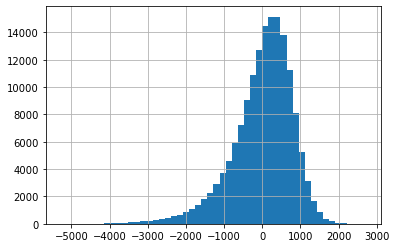

In [330]:
_ = results_df['residuals'].hist(bins=50)

In [331]:
results_df['residuals'].describe()

count    1.570530e+05
mean     9.388377e-14
std      7.921557e+02
min     -5.264405e+03
25%     -4.009855e+02
50%      1.191008e+02
75%      5.361208e+02
max      2.708509e+03
Name: residuals, dtype: float64

## Now, let's predict on the "test set" I created and see how our predictions fare.

In [332]:
test = DeliveryTimeCalculator(upper_outlier_seconds=7200).fit_transform(test_set)
test_labels = train_set['total_delivery_duration_seconds'].to_numpy()

In [333]:
test_set_transformed = full_pipeline.fit_transform(test_set)

In [334]:
test_set_preds = final_model.predict(test_set_transformed)

In [337]:
test_set.head()

,market_id,created_at,actual_delivery_time,store_id,subtotal,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration
175813,2.0,2015-01-24 18:23:56,2015-01-24 19:24:39,3955,1944,12.0,36.0,14.0,495.0
79762,2.0,2015-01-22 19:02:58,2015-01-22 19:25:44,5704,2098,31.0,36.0,28.0,196.0
80915,4.0,2015-02-01 20:39:21,2015-02-01 21:19:24,6323,3135,35.0,35.0,48.0,501.0
155400,2.0,2015-02-16 18:08:25,2015-02-16 18:42:06,892,895,10.0,6.0,3.0,816.0
78044,2.0,2015-02-15 18:55:33,2015-02-15 19:28:10,6884,0,23.0,20.0,23.0,573.0


In [340]:
train_set.head()

,market_id,created_at,actual_delivery_time,store_id,subtotal,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,total_delivery_duration_seconds
178523,3.0,2015-02-10 02:25:28,2015-02-10 03:09:01,1659,1298,0.0,0.0,0.0,821.0,2613.0
89414,4.0,2015-01-23 04:23:13,2015-01-23 05:01:12,3748,1690,78.0,64.0,75.0,406.0,2279.0
94190,1.0,2015-01-24 03:33:32,2015-01-24 04:03:35,6750,3300,63.0,66.0,90.0,296.0,1803.0
136117,5.0,2015-02-17 00:25:38,2015-02-17 01:14:22,6456,3029,23.0,15.0,15.0,773.0,2924.0
53337,4.0,2015-01-26 01:19:16,2015-01-26 02:24:02,6889,3390,71.0,98.0,91.0,758.0,3886.0


In [341]:
test_set.head()

,market_id,created_at,actual_delivery_time,store_id,subtotal,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration
175813,2.0,2015-01-24 18:23:56,2015-01-24 19:24:39,3955,1944,12.0,36.0,14.0,495.0
79762,2.0,2015-01-22 19:02:58,2015-01-22 19:25:44,5704,2098,31.0,36.0,28.0,196.0
80915,4.0,2015-02-01 20:39:21,2015-02-01 21:19:24,6323,3135,35.0,35.0,48.0,501.0
155400,2.0,2015-02-16 18:08:25,2015-02-16 18:42:06,892,895,10.0,6.0,3.0,816.0
78044,2.0,2015-02-15 18:55:33,2015-02-15 19:28:10,6884,0,23.0,20.0,23.0,573.0


In [342]:
test_set = DeliveryTimeCalculator(upper_outlier_seconds=7200).fit_transform(test_set)

In [343]:
print(test_set)

        market_id          created_at actual_delivery_time  store_id  \
175813        2.0 2015-01-24 18:23:56  2015-01-24 19:24:39      3955   
79762         2.0 2015-01-22 19:02:58  2015-01-22 19:25:44      5704   
80915         4.0 2015-02-01 20:39:21  2015-02-01 21:19:24      6323   
155400        2.0 2015-02-16 18:08:25  2015-02-16 18:42:06       892   
78044         2.0 2015-02-15 18:55:33  2015-02-15 19:28:10      6884   
...           ...                 ...                  ...       ...   
92760         4.0 2015-02-06 21:35:34  2015-02-06 22:06:22      2636   
73105         4.0 2015-01-27 21:01:03  2015-01-27 21:39:44      4666   
159516        2.0 2015-01-31 03:56:16  2015-01-31 05:04:41      6074   
33150         4.0 2015-01-30 02:08:40  2015-01-30 03:05:47      1854   
51346         1.0 2015-02-09 03:46:19  2015-02-09 04:33:43      2927   

        subtotal  total_onshift_dashers  total_busy_dashers  \
175813      1944                   12.0                36.0   
79762    

In [344]:
test_labels = test_set['total_delivery_duration_seconds'].to_numpy()

In [345]:
test_set_transformed = full_pipeline.transform(test_set)

In [346]:
final_model_preds = final_model.predict(test_set_transformed)

In [347]:
final_rmse = np.sqrt(MSE(test_labels, final_model_preds))

In [348]:
print(final_rmse)

826.5053696063695


## So the RMSE on the test was even lower, measuring 13 minutes 46 seconds. Given the subject matter expertise in the instructions doc (i.e. that underestimating, or order lateness, is more costly than overestimating) let us examine how our model fares in that regard. In other words, how often we under vs. overpredicting delivery time?

In [356]:
results_df = pd.DataFrame({'predictions': final_model_preds, 'actual': test_labels})

In [357]:
results_df['residuals'] = results_df['predictions'] - results_df['actual']

In [359]:
len(results_df[results_df['residuals'] < 0])/len(results_df)

0.42678921506225015

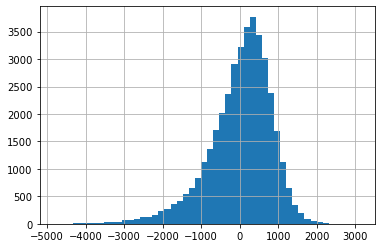

In [360]:
_ = results_df['residuals'].hist(bins=50)

In [361]:
results_df['residuals'].describe()

count    39277.000000
mean        13.383979
std        826.407516
min      -4794.161177
25%       -409.630193
50%        136.981911
75%        566.185459
max       3103.126803
Name: residuals, dtype: float64

In [362]:
results_df['residuals'].quantile(0.05)

-1522.7797898999977

In [363]:
results_df['residuals'].quantile(0.10)

-1039.9447741085162

In [371]:
from scipy import stats
conf_level = 0.95
errors_sq = (final_model_preds - test_labels)
std_error = stats.sem(errors_sq)
ninety_five_conf_int = np.sqrt(stats.t.interval(conf_level, len(errors_sq) - 1,\
                                                loc=errors_sq.mean(), scale = std_error))

In [373]:
from scipy import stats
conf_level = 0.95
errors_sq = (final_model_preds - test_labels) ** 2
std_error = stats.sem(errors_sq)
ninety_five_conf_int = np.sqrt(stats.t.interval(conf_level, len(errors_sq) - 1,\
                                                loc=errors_sq.mean(), scale = std_error))

In [374]:
## This is the 95% confidence interval for the Root Mean Squared Error of our predictions
print(ninety_five_conf_int)

[818.29517337 834.6348071 ]


# I believe the handful of cells above prove this model's effectiveness quite satisfactorily: the headline here is that close to 58% of our predictions are overestimates (meaning actual delivery time time is shorter than the estimate), and even our underestimates are not very common or excessive - only 10% of all orders will be more than 17 minutes late. Moreover, the middle 50% of all orders arrived within 14 minutes of the predicted time - which allows for the construction of a relatively short yet reliable time window to provide users after they've placed an order.

In [349]:
unseen_data = pd.read_csv('predict_data.csv')

In [350]:
print(unseen_data.head())

   market_id           created_at  store_id  subtotal  total_onshift_dashers  \
0        3.0  2015-02-25 02:22:30      5477      7500                    4.0   
1        3.0  2015-02-25 01:14:19      5477      7100                    4.0   
2        4.0  2015-02-22 02:27:44      5477      4500                    9.0   
3        3.0  2015-02-25 01:32:39      5477      1700                    3.0   
4        1.0  2015-02-24 05:20:45      2841      3150                    4.0   

   total_busy_dashers  total_outstanding_orders  \
0                 4.0                       4.0   
1                 1.0                       1.0   
2                 7.0                       6.0   
3                 3.0                       3.0   
4                 4.0                       4.0   

   estimated_store_to_consumer_driving_duration  delivery_id  
0                                         670.0       194096  
1                                         446.0       236895  
2                      

In [351]:
unseen_data['placeholder'] = 0

In [352]:
unseen_data_prepared = full_pipeline.fit_transform(unseen_data)

In [353]:
unseen_data_predictions = final_model.predict(unseen_data_prepared)

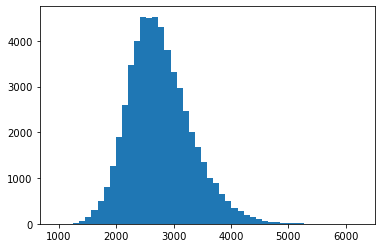

In [355]:
_ = plt.hist(unseen_data_predictions, bins=50)

In [364]:
deliverable = unseen_data[['delivery_id']].copy()

In [365]:
deliverable['predicted_duration'] = pd.Series(unseen_data_predictions)

In [366]:
print(deliverable.head())

   delivery_id  predicted_duration
0       194096         3565.564440
1       236895         3105.981494
2       190868         2559.509448
3       183076         3371.384064
4       186200         3393.031648


In [367]:
deliverable.to_csv('predictions.csv')

In [368]:
unseen_data.shape

(54778, 10)

In [370]:
deliverable.shape

(54778, 2)